In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# APPM 5720 - Homework 3

### Goal
Approximate a function f(x) on $[x_L, x_R]$ using Legendre polynomials of degree q.

\begin{equation*}
f(x) \approx \sum_{k=0}^{q} c(k,i) P_k(r(x))
\end{equation*}

### Unknowns 
$c(k,i)$, where $i$ refers to an element

### Aproach
Calculate the coefficients using the following relations:

\begin{equation*}
\int_{\Omega_i} P_l(r)f(x)dx = \int_{\Omega_i} P_l(r) \sum_{k=0}^{q}c(k,i)P_k(r)dx =  \sum_{k=0}^{q}c(k,i) \left( \frac{1}{2} (x_i - x_{i-1}) \right) \int_{-1}^1 P_l(r)P_k(r)dr = \frac{1}{2}c(l,i)(x_i-x_{i-1})\frac{2}{2l+1}
\end{equation*}

and

\begin{equation*}
\int_{\Omega_i} P_l(r)f(x)dx = \frac{1}{2}(x_i-x_{i-1})\int_{-1}^1 P_l(r) f(x(r))df \approx \frac{1}{2}(x_i-x_{i-1})\sum_{j=0}^q w_j P_l(r_j)f(x(r_j)),
\end{equation*}

where $ l = 0, ..., q$. $P_l$ and $c$ are vectors of length q.

Therefore

\begin{equation*}
c(l,i) = \frac{2l+1}{2} \sum_{j=0}^q w_j P_l(r_j)f(x(r_j))
\end{equation*}

The weights $w_j$ are acquired through the gauss_lobatto function. The evaluation points $x_j$ also come from the gauss_lobatto function but are mapped to $[x_L,x_R]$.


### Note:
This code only builds an approximation over a single element.

In [2]:
# Import sympy code for gauss lobatto nodes
from sympy.core import S, Dummy, pi
from sympy.functions.combinatorial.factorials import factorial
from sympy.functions.elementary.trigonometric import sin, cos
from sympy.functions.elementary.miscellaneous import sqrt
from sympy.functions.special.gamma_functions import gamma
from sympy.polys.orthopolys import (legendre_poly, laguerre_poly,
                                    hermite_poly, jacobi_poly)
from sympy.polys.rootoftools import RootOf
from sympy.core.compatibility import range

In [3]:
# Parameters
num_grdpts = 3
num_elems = num_grdpts - 1
num_nodes = 15

In [4]:
# Calls from Input Control
grdpts = np.array([0.0, 0.3, 1.0])
degree_vec = np.array([12, 12])

In [5]:
def gauss_lobatto(n, n_digits):
    r"""
    Computes the Gauss-Lobatto quadrature [1]_ points and weights.

    The Gauss-Lobatto quadrature approximates the integral:

    .. math::
        \int_{-1}^1 f(x)\,dx \approx \sum_{i=1}^n w_i f(x_i)

    The nodes `x_i` of an order `n` quadrature rule are the roots of `P'_(n-1)`
    and the weights `w_i` are given by:

    .. math::
        &w_i = \frac{2}{n(n-1) \left[P_{n-1}(x_i)\right]^2},\quad x\neq\pm 1\\
        &w_i = \frac{2}{n(n-1)},\quad x=\pm 1

    Parameters
    ==========

    n : the order of quadrature

    n_digits : number of significant digits of the points and weights to return

    Returns
    =======

    (x, w) : the ``x`` and ``w`` are lists of points and weights as Floats.
             The points `x_i` and weights `w_i` are returned as ``(x, w)``
             tuple of lists.

    Examples
    ========

    >>> from sympy.integrals.quadrature import gauss_lobatto
    >>> x, w = gauss_lobatto(3, 5)
    >>> x
    [-1, 0, 1]
    >>> w
    [0.33333, 1.3333, 0.33333]
    >>> x, w = gauss_lobatto(4, 5)
    >>> x
    [-1, -0.44721, 0.44721, 1]
    >>> w
    [0.16667, 0.83333, 0.83333, 0.16667]

    See Also
    ========

    gauss_legendre,gauss_laguerre, gauss_gen_laguerre, gauss_hermite, gauss_chebyshev_t, gauss_chebyshev_u, gauss_jacobi

    References
    ==========

    .. [1] http://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss.E2.80.93Lobatto_rules
    .. [2] http://people.math.sfu.ca/~cbm/aands/page_888.htm
    TAKEN FROM SYMPY
    """
    x = Dummy("x")
    p = legendre_poly(n-1, x, polys=True)
    pd = p.diff(x)
    xi = []
    w = []
    for r in pd.real_roots():
        if isinstance(r, RootOf):
            r = r.eval_rational(S(1)/10**(n_digits+2))
        xi.append(r.n(n_digits))
        w.append((2/(n*(n-1) * p.subs(x, r)**2)).n(n_digits))

    xi.insert(0, -1)
    xi.append(1)
    w.insert(0, (S(2)/(n*(n-1))).n(n_digits))
    w.append((S(2)/(n*(n-1))).n(n_digits))
    return xi, w

In [6]:
def leg_eval(q,x):
    '''
    Evaluate Legendre polynomials of up to degree q at point x
    '''
    if q == 0:
        return np.array([1])
    elif q == 1:
        return np.array([1,x])
    else:
        leg_arr = np.zeros([q])
        leg_arr[0] = 1
        leg_arr[1] = x
        
        # Recursion relation for higher order Leg. polynomials
        for i in range(1,q-1):
            leg_arr[i+1] = ((2*i+1)*x*leg_arr[i] - i*leg_arr[i-1])/(i+1)
        return np.array(leg_arr)

In [7]:
def f(x):
    return np.exp((x-2)**2/2)

In [8]:
### --- Main computation --- ###
### --- Acquire coefficients --- ###
c = np.zeros([degree_vec[0], num_elems])

# Precompute Ldgr polynomials at LGL nodes
r_lgl, w_lgl = gauss_lobatto(num_nodes,16)
r_lgl, w_lgl = np.array(r_lgl), np.array(w_lgl)

lgdr_arr = np.zeros([degree_vec[0], num_nodes])
for i in range(num_nodes):
    lgdr_arr[:,i] = leg_eval(degree_vec[0], r_lgl[i])

### For a single element i
i = 0
xL = grdpts[i]
xR = grdpts[i+1]

# Calculate f(x(r_j))
# Map (xL, xR) -> (-1,1)
x_lgl = 1/2*((xR-xL)*r_lgl + (xR+xL))
x_lgl = x_lgl.astype(float)

for l in range(degree_vec[0]):
    for j in range(num_nodes):
        c[l,i] += (2*l+1)/2 * w_lgl[j] * lgdr_arr[l,j] * f(x_lgl[j])

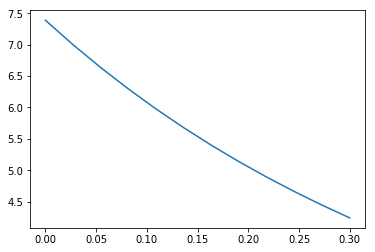

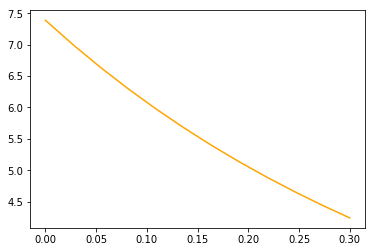

In [34]:
### --- Visualize true fcn values to approximation --- ###
true_fcn = f(np.linspace(xL, xR, degree_vec[0]))

r_dom = (2*np.linspace(xL,xR, degree_vec[0]) - (xR+xL))/(xR-xL)   #r(x) for the approximation
approx_fcn = np.zeros([degree_vec[0]])
for i in range(len(r_dom)):
    approx_lgl = leg_eval(degree_vec[0], r_dom[i])
    approx_fcn[i] = np.dot(c[:,0],approx_lgl)

plt.figure()
plt.plot(np.linspace(xL, xR, degree_vec[0]), true_fcn)
plt.show()

plt.figure()
plt.plot(np.linspace(xL,xR, degree_vec[0]), approx_fcn, 'orange')
plt.show()